# Science User Case - Get Hitomi Data

## 1. Import the Python modules we'll be using.

In [1]:
# Suppress unimportant warnings.
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")
warnings.filterwarnings('ignore', '.*RADECSYS=*', append=True)

import matplotlib.pyplot as plt
import numpy as np

# For downloading files
from astropy.utils.data import download_file

import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
import astropy.visualization as vis
from astropy.wcs import WCS
from astroquery.ned import Ned

import pyvo as vo

from IPython.display import Image as ipImage, display, HTML
import os
import warnings
warnings.filterwarnings('ignore', '.*Unknown element mirrorURL.*', vo.utils.xml.elements.UnknownElementWarning)

The next cell prepares the notebook to display our visualizations.

In [2]:
%matplotlib inline  

## Search the NAVO Registry for Hitomi observations.

Trying to download Hitomi observations directly. 

In [3]:
services = vo.regsearch(servicetype='scs', keywords=['hitomi'])
services.to_table()['ivoid', 'short_name', 'res_title']

ivoid,short_name,res_title
object,object,object
ivo://nasa.heasarc/hitomaster,HITOMASTER,Hitomi Master Catalog


### Look for Perseus in Hitomaster catalog

In [4]:
# Better to use the Perseus --> Abell 426
coord = SkyCoord.from_name("Abell426")
print(coord)

<SkyCoord (ICRS): (ra, dec) in deg
    (49.94667, 41.51306)>


In [5]:
## Use the one that's CFAZ. 
##  Use list comprehension to check each service's short_name attribute and use the first.
hitomi_cone_service = [s for s in services if 'HITO' in s.short_name][0] 

## We are searching for sources within 10 arcminutes of M51. 
results = hitomi_cone_service.search(pos=coord, radius=10*u.arcmin)
results.to_table()

name,obsid,ra,dec,time,exposure,sxsifonfov,sxiifonfov,hxi1ifonfov,hxi2ifonfov,sgd1ifonfov,sgd2ifonfov,Search_Offset
,,deg,deg,mjd,s,,,,,,,
object,object,float64,float64,float64,float64,object,object,object,object,object,object,float64
Perseus_core,100040010,49.87414,41.48386,57442.091410014,48723.99476,YY,NN,NN,NN,NN,NN,3.7003
Perseus_adjustment,100040060,49.95103,41.51225,57454.026343019,45793.67852,YY,YY,NN,NN,NN,NN,0.2018
Perseus_core_adjustment,100040020,49.93161,41.51939,57443.092507149,97441.42291,YY,NN,NN,NN,NN,NN,0.7759
Perseus,100040040,49.93212,41.51986,57452.500002677,68133.51563,YY,NN,NN,NN,NN,NN,0.7705
Perseus,100040030,49.93242,41.52013,57451.028623610,72511.57813,YY,NN,NN,NN,NN,NN,0.7682
Perseus,100040050,49.93226,41.52148,57453.817188426,5451.23438,YY,NN,NN,NN,NN,NN,0.8209


Now we know the obs ID for the potentially useful observations

# Download file 
### -- the Clunky Way! 
Ideally we could generalize this a bit more, but because we know from xamin that the files are in the following directory, we just need to allow use to insert the observation id to the following directory: https://heasarc.gsfc.nasa.gov/FTP/hitomi/data/obs/1/

The row could be a prompt to user... for this example, assume we want row 4 (index =3)

In [6]:
row = 4  # could make this interactive
pyrow = row-1   # python row index
obsid = results[pyrow]['obsid'].decode("utf-8")
print(obsid)

100040040


In [7]:
url = 'https://heasarc.gsfc.nasa.gov/FTP/hitomi/data/obs/1//'+str(obsid)+'/'

Turns out that this doesn't quite work because the files are in subdirectories. So we need to know where the relevant file is located. See here for example: https://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/w3hdprods.pl?files=Preview&Coordinates=Equatorial&Equinox=2000&CheckSize=1&showgifs=1&Target=heasarc_hitomaster%7C%7C%7C__row%3D39%7C%7C&popupFrom=Query%20Results&querytime=1602628274 

Once we figure out the files, we can create the correct path name by appending relevant subdirectories and names. 

## The better way:  try datalink! (a bit beta still)

### Next trying with tap service: 

In [8]:
service=vo.regsearch(keywords=['heasarc'],servicetype='tap')[0]
service.describe()

Table Access Protocol Service
HEASARC Xamin Catalog Interface
Short Name: HEASARC
IVOA Identifier: ivo://nasa.heasarc/services/xamin
Base URL: https://heasarc.gsfc.nasa.gov/xamin/vo/tap

The HEASARC is NASA domain archive for high-energy and microwave astronomy.
The Xamin interface provides access to over 600 observation and object tables.
This includes observation tables for more than 30 missions and observatories
and hundreds of derived object tables. Non-high energy tables are included to
make it easier for users to compare information.

Subjects: HEASARC
Waveband Coverage:


In [9]:
coord = SkyCoord.from_name("Abell426")
print(coord)
#  Construct a query to get objects near our source:
query="""SELECT * FROM hitomaster WHERE 
        1=CONTAINS(POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {}, {}, 1))""".format(coord.ra.deg,coord.dec.deg)
results = service.search(query)


<SkyCoord (ICRS): (ra, dec) in deg
    (49.94667, 41.51306)>


In [10]:
links=results[0].getdatalink()
links.to_table()['description','content_type']

description,content_type
object,object
Hitomi observation,application/x-votable+xml;content=datalink
Hitomi observation,text/html


### First a little orientation...

In general, since we don't know which one, a priori, will contain the links to images, spectra, etc. we need to iterate over the links. In this case, we can see that the first link contains a datalink, meaning that we can further check what downloadable data are available within the subdirectories.

In [11]:
# -- more general loop, but in this case, we can see that the links[0] has the content=datalink...
#for link in links:
#    if "datalink" in link.content_type:
#        break
link=links[0]  # short cut for our specific case...
link.getdatalink().to_table()['description','content_type']

description,content_type
object,object
Hitomi observation,text/html
Auxil All Data,application/x-votable+xml;content=datalink
Auxil All Data,text/html
Log All Files,application/x-votable+xml;content=datalink
Log All Files,text/html
HXI All Data,application/x-votable+xml;content=datalink
HXI All Data,text/html
SGD All Data,application/x-votable+xml;content=datalink
SGD All Data,text/html


So at this point, you need to see what files are included. But more than this organization, you probably care about getting specific types of files. So defining a way to extract only those files is useful:

In [12]:
def linkwalker( result, level, keyword=None ):
    print("LEVEL {}".format(level))
    try:
        result2=result.getdatalink()
        if keyword is None:
            print(result2.to_table()['description','content_type'])
        else:
            t=result2.to_table()['description','content_type']
            #print([r for r in t if keyword in r['description'].lower() or keyword in r['content_type'].lower()])
            for r in t:
                if keyword in r['description'].lower() or keyword in r['content_type'].lower():
                    print(r)
                
    except Exception as e:
        print("Exception {}".format(e))
        return
    for link in [l for l in result2 if "datalink" in l.content_type]:
        linkwalker(link, level+1, keyword)
    
    return

For example, looking at the GIF files: 

In [13]:
linkwalker(link, 0,keyword=b'gif')

LEVEL 0
LEVEL 1
LEVEL 1
LEVEL 1
LEVEL 1
LEVEL 1
LEVEL 1
         description           content_type
------------------------------ ------------
SXS Image Plot-All Instruments    image/gif
           description            content_type
--------------------------------- ------------
SXS Spectrum Plot-All Instruments    image/gif


So we can see the files we want... So, how do we grab these or display them?

In [14]:
new=link.getdatalink()
new.to_table()['description', 'content_type']

description,content_type
object,object
Hitomi observation,text/html
Auxil All Data,application/x-votable+xml;content=datalink
Auxil All Data,text/html
Log All Files,application/x-votable+xml;content=datalink
Log All Files,text/html
HXI All Data,application/x-votable+xml;content=datalink
HXI All Data,text/html
SGD All Data,application/x-votable+xml;content=datalink
SGD All Data,text/html


In [15]:
sxsfiles=new[11].getdatalink()
sxsfiles.to_table()['description', 'content_type']

description,content_type
object,object
SXS All Data,text/html
SXS Housekeeping,text/html
SXS Housekeeping,application/fits
SXS Products,text/html
SXS Ancillary Response,application/fits
SXS Image Plot-All Instruments,image/gif
SXS Image,application/fits
SXS Response Matrix,application/fits
SXS Spectrum Plot-All Instruments,image/gif


We see that sxsfile[5] has the image 'GIF' (which we can determine more elegantly), as before... 

In [16]:
def getrow( result, keyword=None ):
    index=0
    ind=[]
    t=result.to_table()['description','content_type']
    for r in t:
        if keyword in r['description'].lower() or keyword in r['content_type'].lower():
            ind.append(index)
        index=index+1
    return(ind)

In [24]:
file=getrow(sxsfiles, keyword=b'gif')

At this point, you can get the urls directly: 

In [25]:
sxsfiles.to_table()['access_url'][data]

https://heasarc.gsfc.nasa.gov/FTP/hitomi/data/obs/1//100040010/sxs/products/ah100040010_img.gif
https://heasarc.gsfc.nasa.gov/FTP/hitomi/data/obs/1//100040010/sxs/products/ah100040010_pi.gif


Or you can display directly: 

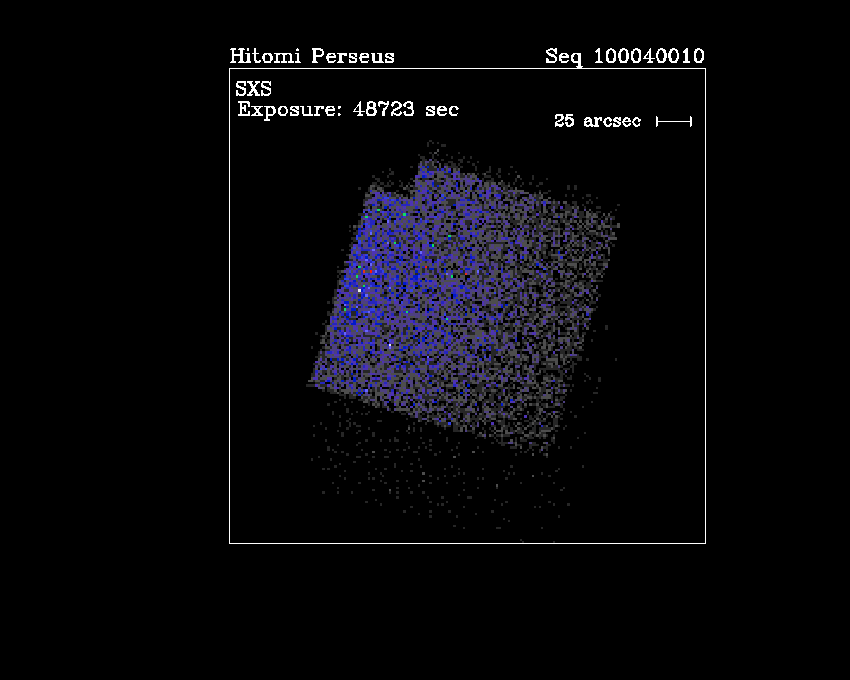

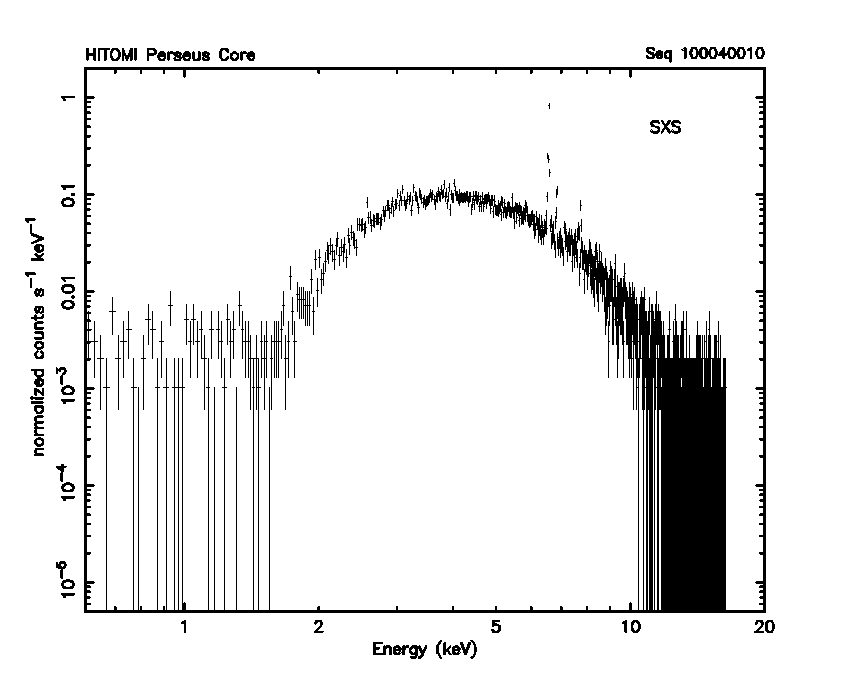

In [26]:
im=file[0]     # the image data
sp=file[1]    # the spectrum
display(ipImage(data=sxsfiles[im].getdataset().data))
display(ipImage(data=sxsfiles[sp].getdataset().data))

## Get FITS files: 
So probably what is useful are the FITS files. But I just don't know which ones are the relevant ones so leave to you from here! But here's my guess... need the event file?

In [27]:
linkwalker(results[0], 0,keyword=b'event')

LEVEL 0
LEVEL 1
LEVEL 2
LEVEL 2
LEVEL 2
  description      content_type  
---------------- ----------------
HXI CAMS1 Events application/fits
  description      content_type  
---------------- ----------------
HXI CAMS2 Events application/fits
LEVEL 2
LEVEL 2
LEVEL 2
        description            content_type  
---------------------------- ----------------
SXS Unfiltered Antico Events application/fits
   description       content_type  
------------------ ----------------
SXS Lost Event GTI application/fits
           description               content_type  
---------------------------------- ----------------
SXS Unfiltered Science Events-Open application/fits
      description         content_type  
----------------------- ----------------
SXS Cal Pixel 12 Events application/fits


Again, guessing that the SXS Unfiltered Science events is what you want, this is the SXS file again.... so taking some shortcuts from above, but filtering now on 'events':

In [28]:
file=getrow(sxsfiles, keyword=b'events')

### Downloading the data corresponding to the "SXS Unfiltered Science Events" will be data[1] (Note, this takes some time to download):

Again, you can do this two ways. Get the URL and download directly or read data into the notebook. Since the latter crashed the notebook, I advise on the former!

#### Get URL:

You can click and download this from the link 

In [29]:
evt=file[1]
sxsfiles.to_table()['access_url'][evt]

b'https://heasarc.gsfc.nasa.gov/FTP/hitomi/data/obs/1//100040010/sxs/event_uf/ah100040010sxs_p0px1010_uf.evt.gz'

#### Download into notebook directly
Caution: may crash notebook!

In [30]:

#sxsfiles[evt].getdataset().data